In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/SNAP'

Mounted at /content/drive
/content/drive/MyDrive/SNAP


In [3]:
import os

data_root = './data/'
processed_data_root = os.path.join(data_root, 'processed/')
figures_root = os.path.join(data_root, 'figures/')

os.makedirs(processed_data_root, exist_ok=True)
os.makedirs(figures_root, exist_ok=True)

device = 'cuda'

In [4]:
from dimensionality import figure_utils

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from itertools import product

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Loading the data


In [6]:
# Load in the data

# We ran into problems with activations with this model and removed it from the experiments for the submission.
exclude_models = ['vit_b_16']

region_list = ['V1',
               'V2',
              #  'V4',
              #  'IT'
               ]

# Only looking at full activations, no random projections
activation_pooling = ['None']
rand_projections = ["None"]


pooling_list = []
for item in product(activation_pooling, rand_projections):
    pooling_list += ["_RandProj_".join(item)]

all_reg_hist, all_processed_data, all_data_kwargs = figure_utils.get_processed_data_figs(region_list,
                                                                                         pooling_list,
                                                                                         trained=True,
                                                                                         exclude_models=exclude_models)
(all_reg_hist_random,
 all_processed_data_random,
 all_data_kwargs_random) = figure_utils.get_processed_data_figs(region_list,
                                                                pooling_list,
                                                                trained=False,
                                                                exclude_models=exclude_models)

# Set some constant values for all of the figures.


In [7]:
pooling = 'None_RandProj_None'
p_idx = -5 # Corresponds to 60/40 train/test split

c_map_min_contours = 0.25
c_map_max_contours = 1

# Limits that are good for the training data only
x_lims = {'V1': [0.02, 0.07],
          'V2': [0.02, 0.07],
          'V4': [0.0014, 0.0065],
          'IT': [0.0014, 0.0065]}

y_lims = {'V1': [8, 12],
          'V2': [8, 12],
          'V4': [23, 41],
          'IT': [23, 41]}


## Figure 1: Theory = Empirical


V1: P = 0.6090225563909775, 13 Models
V2: P = 0.6090225563909775, 13 Models


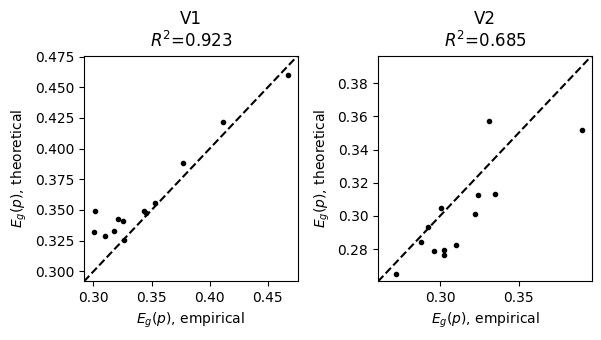

In [8]:
plt.figure(figsize=(12, 3.5))

for r_idx, region in enumerate(region_list):
    plt.subplot(1, 4, r_idx+1)

    x_val = []
    y_val = []
    p_val = []
    p_max = []
    for model, model_data in all_processed_data[region][pooling].items():
        p_val.append(model_data['pvals_mode'][:, p_idx])
        p_max.append(model_data['pvals_mode'][:, -1])

        x_val.append(model_data['gen_errs'][:, p_idx])

        r = model_data['dyn_weight_rads'][:, p_idx]
        sqrt_d = model_data['dyn_tads'][:, p_idx]

        y_val.append(r * sqrt_d)

    x_val = np.concatenate(x_val)
    y_val = np.concatenate(y_val)
    p_val = np.concatenate(p_val)
    p_max = np.concatenate(p_max)

    assert (len(np.unique(p_val)) == 1)
    assert (len(np.unique(p_max)) == 1)

    r = np.corrcoef(x_val, y_val)[0, 1]

    plt.scatter(x_val,
                y_val,
                marker='.',
                color='k'
                )

    p_frac = np.unique(p_val)[0]/np.unique(p_max)[0]
    plt.title('%s\n$R^2$=%0.3f' % (region, r**2))
    plt.xlabel('$E_g(p)$, empirical')
    plt.ylabel('$E_g(p)$, theoretical')

    x_l = plt.xlim()
    y_l = plt.ylim()

    lims = [min(x_l[0], y_l[0]), max(x_l[1], y_l[1])]
    plt.xlim([lims[0], lims[1]])
    plt.ylim([lims[0], lims[1]])
    plt.plot([lims[0], lims[1]],
             [lims[0], lims[1]],
             'k--')

    print('%s: P = %s, %s Models' % (region, p_frac, len(x_val)))

plt.tight_layout()
plt.savefig(figures_root + 'Theory_vs_Empirical_Values.pdf')


## Figure 2: All Model and Layer Contour Plots


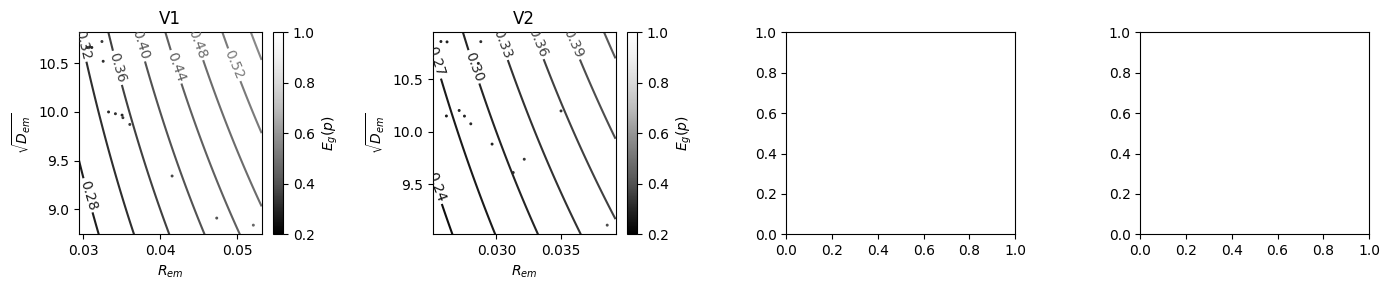

In [9]:
# Showing the generalization error coloring

# Good for training data, showing the generalization error
cmap_min = 0.2
cmap_max = 1.

figs, ax = plt.subplots(nrows=1,
                        ncols=4,
                        figsize=(14, 3),
                        )
ax = ax.ravel()

_ = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                      pooling,
                                      p_idx=p_idx,
                                      x_lims=None,  # x_lims,
                                      y_lims=None,  # y_lims,
                                      coloring='gen_errs',
                                      c_map_min=cmap_min,
                                      c_map_max=cmap_max,
                                      marker_size=5,
                                      ax_handle=ax,
                                      cmap='Greys_r',
                                      save_figures=True,
                                      figure_root=figures_root)

### Figure 3 : Layer Depth


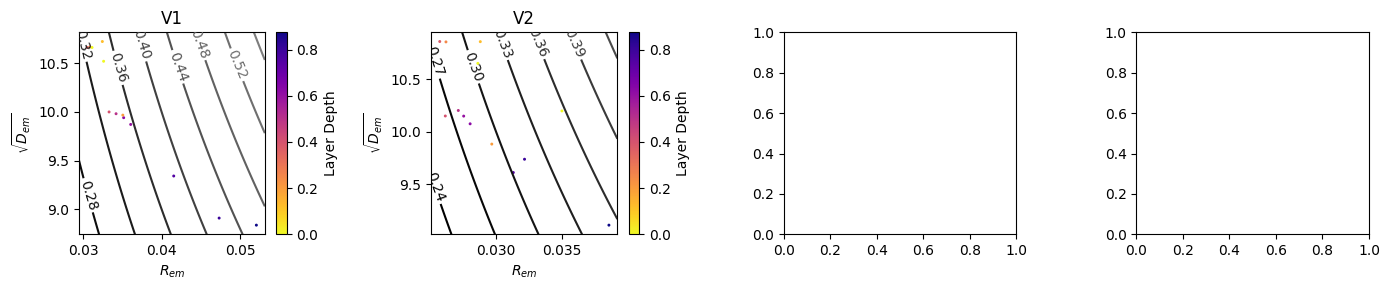

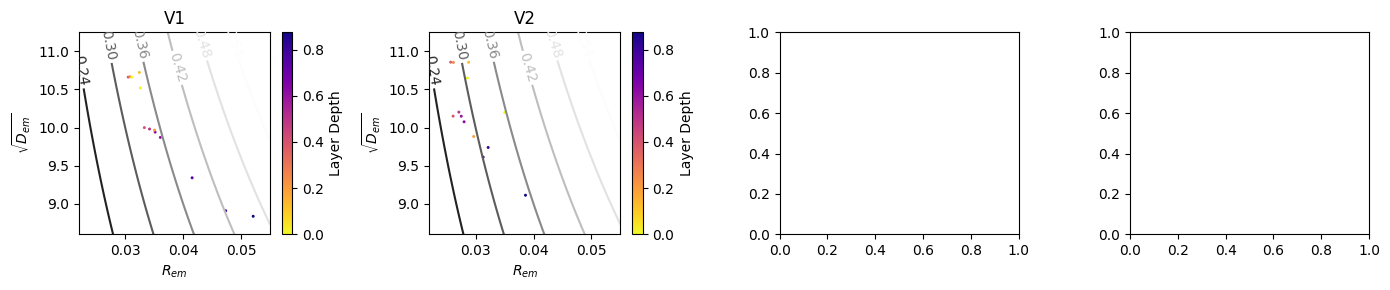

In [10]:
# Good for training data, showing the generalization error
figs, ax = plt.subplots(nrows=1,
                        ncols=4,
                        figsize=(14, 3),
                        )
ax = ax.ravel()

layer_data = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                               pooling,
                                               p_idx=p_idx,
                                               # x_lims=x_lims,
                                               # y_lims=y_lims,
                                               coloring='layer_depth_normalized',
                                               c_map_min_contours=c_map_min_contours,
                                               c_map_max_contours=c_map_max_contours,
                                               cmap=plt.cm.plasma_r,
                                               c_bar_label='Layer Depth',
                                               marker_size=5,
                                               ax_handle=ax,
                                               cmap_contours='Greys_r',
                                               save_figures=True,
                                               figure_root=figures_root)

plt.savefig(figures_root + 'LayerwiseContourColoring_Full.pdf')
plt.savefig(figures_root + 'LayerwiseContourColoring_Full.png')

# Make a zoomed in version
figs, ax = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(14, 3),
)
ax = ax.ravel()

x_lims = {'V1': [0.022, 0.055],
          'V2': [0.022, 0.055],
          'V4': [0.004, 0.012],
          'IT': [0.004, 0.012]}

y_lims = {'V1': [8.6, 11.25],
          'V2': [8.6, 11.25],
          'V4': [38, 50],
          'IT': [39, 51.5]}

cropped_contour_min_max = [0.2, 0.55]
layer_data = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                               pooling,
                                               p_idx=p_idx,
                                               x_lims=x_lims,
                                               y_lims=y_lims,
                                               coloring='layer_depth_normalized',
                                               c_map_min_contours=cropped_contour_min_max[0],
                                               c_map_max_contours=cropped_contour_min_max[1],
                                               cmap=plt.cm.plasma_r,
                                               c_bar_label='Layer Depth',
                                               marker_size=5,
                                               ax_handle=ax,
                                               cmap_contours='Greys_r',
                                               save_figures=False,
                                               figure_root=figures_root)
plt.savefig(figures_root + 'LayerwiseContourColoring_Cropped.pdf')
plt.savefig(figures_root + 'LayerwiseContourColoring_Cropped.png')


## Figure 4: Robust vs. Standard


IndexError: ignored

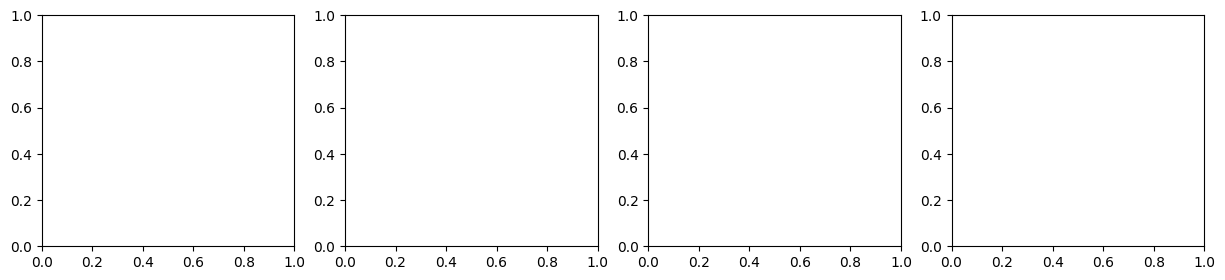

In [11]:
pooling = pooling_list[-1]

figs, ax = plt.subplots(nrows=1,
                        ncols=4,
                        figsize=(15, 3),
                        )
ax = ax.ravel()

robust_contour_min_max = [0.2, 0.5]

x_lims = {'V1': [0.022, 0.044],
          'V2': [0.022, 0.044],
          'V4': [0.004, 0.011],
          'IT': [0.004, 0.011]}

y_lims = {'V1': [8.75, 11.25],
          'V2': [8.75, 11.25],
          'V4': [41.5, 50],
          'IT': [41.5, 50]}

# Limits that are good for the training data only
region_data_1 = figure_utils.plot_region_contours(all_reg_hist,
                                                  region_list,
                                                  pooling,
                                                  p_idx=p_idx,
                                                  x_lims=x_lims,
                                                  y_lims=y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.1,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Blues,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=robust_contour_min_max[0],
                                                  c_map_max_contours=robust_contour_min_max[1],
                                                  ax_handle=ax,
                                                  marker_size=50,
                                                  c_bar_label='Layer, ResNet50',
                                                  model_subset=['resnet50'],
                                                  make_contours=False,
                                                  figure_root=figures_root)

region_data_2 = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                                  pooling,
                                                  p_idx=p_idx,
                                                  x_lims=x_lims,
                                                  y_lims=y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.1,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Greens,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=robust_contour_min_max[0],
                                                  c_map_max_contours=robust_contour_min_max[1],
                                                  ax_handle=ax,
                                                  marker_size=20,
                                                  marker_style='s',
                                                  c_bar_label='Layer, ResNet50 L2-3 Robust',
                                                  model_subset=['robust_resnet50_l2_3'],
                                                  make_contours=True,
                                                  figure_root=figures_root)

for region in region_list:
    p_idx = region_data_1[region]['p_idx']

    starting_points_r = region_data_1[region]['all_models']['dyn_weight_rads'][:, p_idx]
    starting_points_d = region_data_1[region]['all_models']['dyn_tads'][:, p_idx]
    order_1 = region_data_1[region]['all_models']['layers']

    order_2 = [list(region_data_2[region]['all_models']['layers']).index(o_name) for o_name in order_1]
    end_points_r = region_data_2[region]['all_models']['dyn_weight_rads'][:, p_idx][order_2]
    end_points_d = region_data_2[region]['all_models']['dyn_tads'][:, p_idx][order_2]

    for (r_1, r_2, d_1, d_2) in zip(starting_points_r, end_points_r,
                                    starting_points_d, end_points_d):
        region_data_1[region]['ax'].annotate('',
                                             xy=(r_2, d_2), xytext=(r_1, d_1),
                                             zorder=0,
                                             arrowprops=dict(facecolor='black', width=0.25,
                                                             headwidth=4, headlength=6))


plt.savefig(figures_root + 'RobustL2_AllRegions_Trained_RvsDContour.pdf')
plt.savefig(figures_root + 'RobustL2_AllRegions_Trained_RvsDContour.png')

In [ ]:
pooling = pooling_list[-1]

figs, ax = plt.subplots(nrows=1,
                        ncols=4,
                        figsize=(15, 3),
                        )
ax = ax.ravel()

robust_contour_min_max = [0.15, 0.5]

x_lims = {'V1': [0.022, 0.046],
          'V2': [0.022, 0.046],
          'V4': [0.004, 0.010],
          'IT': [0.004, 0.010]}

y_lims = {'V1': [8.6, 11.25],
          'V2': [8.6, 11.25],
          'V4': [41.5, 50],
          'IT': [41.5, 50]}

# Limits that are good for the training data only
region_data_1 = figure_utils.plot_region_contours(all_reg_hist,
                                                  region_list,
                                                  pooling,
                                                  p_idx=p_idx,
                                                  x_lims=x_lims,
                                                  y_lims=y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.2,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Blues,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=robust_contour_min_max[0],
                                                  c_map_max_contours=robust_contour_min_max[1],
                                                  ax_handle=ax,
                                                  marker_size=50,
                                                  c_bar_label='Layer, ResNet50',
                                                  model_subset=['resnet50'],
                                                  make_contours=False)

region_data_2 = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                                  pooling,
                                                  p_idx=p_idx,
                                                  x_lims=x_lims,
                                                  y_lims=y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.2,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Reds,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=robust_contour_min_max[0],
                                                  c_map_max_contours=robust_contour_min_max[1],
                                                  ax_handle=ax,
                                                  marker_size=20,
                                                  marker_style='s',
                                                  c_bar_label='Layer, ResNet50 Linf-4 Robust',
                                                  model_subset=['robust_resnet50_linf_4'],
                                                  make_contours=True)

for region in region_list:
    p_idx = region_data_1[region]['p_idx']

    starting_points_r = region_data_1[region]['all_models']['dyn_weight_rads'][:, p_idx]
    starting_points_d = region_data_1[region]['all_models']['dyn_tads'][:, p_idx]
    order_1 = region_data_1[region]['all_models']['layers']

    order_2 = [list(region_data_2[region]['all_models']['layers']).index(o_name) for o_name in order_1]
    end_points_r = region_data_2[region]['all_models']['dyn_weight_rads'][:, p_idx][order_2]
    end_points_d = region_data_2[region]['all_models']['dyn_tads'][:, p_idx][order_2]

    for (r_1, r_2, d_1, d_2) in zip(starting_points_r, end_points_r,
                                    starting_points_d, end_points_d):
        region_data_1[region]['ax'].annotate('',
                                             xy=(r_2, d_2), xytext=(r_1, d_1),
                                             zorder=0,
                                             arrowprops=dict(facecolor='black', width=0.25,
                                                             headwidth=4, headlength=6))

plt.savefig(figures_root + 'RobustLinf_AllRegions_Trained_RvsDContour.pdf')
plt.savefig(figures_root + 'RobustLinf_AllRegions_Trained_RvsDContour.png')


In [ ]:
pooling = pooling_list[-1]

figs, ax = plt.subplots(nrows=1,
                        ncols=4,
                        figsize=(15, 3),
                        )
ax = ax.ravel()

robust_contour_min_max = [0.15, 0.5]

x_lims = {'V1': [0.022, 0.046],
          'V2': [0.022, 0.046],
          'V4': [0.004, 0.010],
          'IT': [0.004, 0.010]}

y_lims = {'V1': [8.6, 11.25],
          'V2': [8.6, 11.25],
          'V4': [41.5, 50],
          'IT': [41.5, 50]}

# Limits that are good for the training data only
region_data_1 = figure_utils.plot_region_contours(all_reg_hist,
                                                  region_list,
                                                  pooling,
                                                  p_idx=p_idx,
                                                  x_lims=x_lims,
                                                  y_lims=y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.2,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Blues,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=robust_contour_min_max[0],
                                                  c_map_max_contours=robust_contour_min_max[1],
                                                  ax_handle=ax,
                                                  marker_size=50,
                                                  c_bar_label='Layer, ResNet50',
                                                  model_subset=['resnet50'],
                                                  make_contours=False)

region_data_2 = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                                  pooling,
                                                  p_idx=p_idx,
                                                  x_lims=x_lims,
                                                  y_lims=y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.2,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Reds,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=robust_contour_min_max[0],
                                                  c_map_max_contours=robust_contour_min_max[1],
                                                  ax_handle=ax,
                                                  marker_size=20,
                                                  marker_style='s',
                                                  c_bar_label='Layer, ResNet50 Barlowtwins',
                                                  model_subset=['barlowtwins'],
                                                  make_contours=True)

for region in region_list:
    p_idx = region_data_1[region]['p_idx']

    starting_points_r = region_data_1[region]['all_models']['dyn_weight_rads'][:, p_idx]
    starting_points_d = region_data_1[region]['all_models']['dyn_tads'][:, p_idx]
    order_1 = region_data_1[region]['all_models']['layers']

    order_2 = [list(region_data_2[region]['all_models']['layers']).index(o_name) for o_name in order_1]
    end_points_r = region_data_2[region]['all_models']['dyn_weight_rads'][:, p_idx][order_2]
    end_points_d = region_data_2[region]['all_models']['dyn_tads'][:, p_idx][order_2]

    for (r_1, r_2, d_1, d_2) in zip(starting_points_r, end_points_r,
                                    starting_points_d, end_points_d):
        region_data_1[region]['ax'].annotate('', xy=(r_2, d_2), xytext=(r_1, d_1),
                                             arrowprops=dict(facecolor='black', width=0.25, headwidth=4, headlength=6),
                                             zorder=0)

plt.savefig(figures_root + 'BarlowTwins_AllRegions_Trained_RvsDContour.pdf')
plt.savefig(figures_root + 'BarlowTwins_AllRegions_Trained_RvsDContour.png')

In [ ]:
pooling = pooling_list[-1]

figs, ax = plt.subplots(nrows=1,
                        ncols=4,
                        figsize=(15, 3),
                        )
ax = ax.ravel()

robust_contour_min_max = [0.15, 0.5]

x_lims = {'V1': [0.022, 0.046],
          'V2': [0.022, 0.046],
          'V4': [0.004, 0.010],
          'IT': [0.004, 0.010]}

y_lims = {'V1': [8.6, 11.25],
          'V2': [8.6, 11.25],
          'V4': [41.5, 50],
          'IT': [41.5, 50]}

# Limits that are good for the training data only
region_data_1 = figure_utils.plot_region_contours(all_reg_hist,
                                                  region_list,
                                                  pooling,
                                                  p_idx=p_idx,
                                                  x_lims=x_lims,
                                                  y_lims=y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.2,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Blues,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=robust_contour_min_max[0],
                                                  c_map_max_contours=robust_contour_min_max[1],
                                                  ax_handle=ax,
                                                  marker_size=50,
                                                  c_bar_label='Layer, ResNet50',
                                                  model_subset=['resnet50'],
                                                  make_contours=False)

region_data_2 = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                                  pooling,
                                                  p_idx=p_idx,
                                                  x_lims=x_lims,
                                                  y_lims=y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.2,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Reds,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=robust_contour_min_max[0],
                                                  c_map_max_contours=robust_contour_min_max[1],
                                                  ax_handle=ax,
                                                  marker_size=20,
                                                  marker_style='s',
                                                  c_bar_label='Layer, ResNet50 MOCO_V2',
                                                  model_subset=['moco_resnet50'],
                                                  make_contours=True)

for region in region_list:
    p_idx = region_data_1[region]['p_idx']

    starting_points_r = region_data_1[region]['all_models']['dyn_weight_rads'][:, p_idx]
    starting_points_d = region_data_1[region]['all_models']['dyn_tads'][:, p_idx]
    order_1 = region_data_1[region]['all_models']['layers']

    order_2 = [list(region_data_2[region]['all_models']['layers']).index(o_name) for o_name in order_1]
    end_points_r = region_data_2[region]['all_models']['dyn_weight_rads'][:, p_idx][order_2]
    end_points_d = region_data_2[region]['all_models']['dyn_tads'][:, p_idx][order_2]

    for (r_1, r_2, d_1, d_2) in zip(starting_points_r, end_points_r,
                                    starting_points_d, end_points_d):
        region_data_1[region]['ax'].annotate('', xy=(r_2, d_2), xytext=(r_1, d_1),
                                             arrowprops=dict(facecolor='black', width=0.25, headwidth=4, headlength=6),
                                             zorder=0)

plt.savefig(figures_root + 'Moco_AllRegions_Trained_RvsDContour.pdf')
plt.savefig(figures_root + 'Moco_AllRegions_Trained_RvsDContour.png')


# Trained Vs. Untrained Comparison


In [ ]:
figs, ax = plt.subplots(nrows=1,
    ncols=4,
    figsize=(15, 3),
)
ax = ax.ravel()

# Limits that are good for the training data only
x_lims = {'V1': [0.022, 0.06],
          'V2': [0.022, 0.06],
          'V4': [0.004, 0.02],
          'IT': [0.004, 0.02]}

y_lims = {'V1': [8.5, 11.2],
          'V2': [8.5, 11.2],
          'V4': [35, 50],
          'IT': [35, 50]}

p_idx_plot = -5

region_data_1 = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                                  pooling,
                                                  p_idx=p_idx_plot,
                                                  x_lims=None,  # x_lims,
                                                  y_lims=None,  # y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.1,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Blues,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=c_map_min_contours,
                                                  c_map_max_contours=3,
                                                  ax_handle=ax,
                                                  marker_size=10,
                                                  c_bar_label='Layer, Trained',
                                                  model_subset=None,
                                                  make_contours=False)

region_data_2 = figure_utils.plot_region_contours(all_reg_hist_random, region_list,
                                                  pooling,
                                                  p_idx=p_idx_plot,
                                                  x_lims=None,  # x_lims,
                                                  y_lims=None,  # y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.1,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Greens,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=c_map_min_contours,
                                                  c_map_max_contours=3,
                                                  ax_handle=ax,
                                                  marker_size=10,
                                                  c_bar_label='Layer, Random',
                                                  model_subset=None,
                                                  make_contours=True)

for region in region_list:
    p_idx = region_data_1[region]['p_idx']

    starting_points_r = region_data_1[region]['all_models']['dyn_weight_rads'][:, p_idx]
    starting_points_d = region_data_1[region]['all_models']['dyn_tads'][:, p_idx]
    order_1 = region_data_1[region]['all_models']['models_plus_layer']

    order_2 = []
    for o_name in order_1:
        try:
            order_2.append(list(region_data_2[
                region]['all_models']['models_plus_layer']).index(o_name))
        except:
            print('Problem With %s' % o_name)

    end_points_r = region_data_2[region]['all_models']['dyn_weight_rads'][:, p_idx][order_2]
    end_points_d = region_data_2[region]['all_models']['dyn_tads'][:, p_idx][order_2]

    for (r_1, r_2, d_1, d_2) in zip(starting_points_r, end_points_r,
                                    starting_points_d, end_points_d):
        region_data_1[region]['ax'].plot([r_1, r_2],
                                         [d_1, d_2],
                                         color='Grey',
                                         alpha=0.1,
                                         zorder=0)

plt.savefig(figures_root + 'RandomVsTrained_AllRegions_Trained_RvsDContour_full.pdf')
plt.savefig(figures_root + 'RandomVsTrained_AllRegions_Trained_RvsDContour_full.png')


In [ ]:
figs, ax = plt.subplots(nrows=1,
                        ncols=4,
                        figsize=(15, 3),
                        )
ax = ax.ravel()

# Limits that are good for the training data only
x_lims = {'V1': [0.022, 0.06],
          'V2': [0.022, 0.06],
          'V4': [0.0038, 0.02],
          'IT': [0.0038, 0.02]}

y_lims = {'V1': [8.5, 11.2],
          'V2': [8.5, 11.2],
          'V4': [36, 51],
          'IT': [36, 51]}

p_idx_plot = -5

region_data_1 = figure_utils.plot_region_contours(all_reg_hist, region_list,
                                                  pooling,
                                                  p_idx=p_idx_plot,
                                                  x_lims=x_lims,
                                                  y_lims=y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.1,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Blues,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=c_map_min_contours,
                                                  c_map_max_contours=c_map_max_contours,
                                                  ax_handle=ax,
                                                  marker_size=10,
                                                  c_bar_label='Layer, Trained',
                                                  model_subset=None,
                                                  make_contours=False)

region_data_2 = figure_utils.plot_region_contours(all_reg_hist_random, region_list,
                                                  pooling,
                                                  p_idx=p_idx_plot,
                                                  x_lims=x_lims,
                                                  y_lims=y_lims,
                                                  coloring='layer_depth_normalized',
                                                  c_map_min=-0.1,
                                                  c_map_max=1,
                                                  cmap=plt.cm.Greens,
                                                  cmap_contours=plt.cm.Greys_r,
                                                  c_map_min_contours=c_map_min_contours,
                                                  c_map_max_contours=c_map_max_contours,
                                                  ax_handle=ax,
                                                  marker_size=10,
                                                  c_bar_label='Layer, Random',
                                                  model_subset=None,
                                                  make_contours=True)

for region in region_list:
    p_idx = region_data_1[region]['p_idx']

    starting_points_r = region_data_1[region]['all_models']['dyn_weight_rads'][:, p_idx]
    starting_points_d = region_data_1[region]['all_models']['dyn_tads'][:, p_idx]
    order_1 = region_data_1[region]['all_models']['models_plus_layer']

    order_2 = []
    for o_name in order_1:
        try:
            order_2.append(list(region_data_2[
                region]['all_models']['models_plus_layer']).index(o_name))
        except:
            print('Problem With %s' % o_name)

    end_points_r = region_data_2[region]['all_models']['dyn_weight_rads'][:, p_idx][order_2]
    end_points_d = region_data_2[region]['all_models']['dyn_tads'][:, p_idx][order_2]

    for (r_1, r_2, d_1, d_2) in zip(starting_points_r, end_points_r,
                                    starting_points_d, end_points_d):
        region_data_1[region]['ax'].plot([r_1, r_2],
                                         [d_1, d_2],
                                         color='Grey',
                                         alpha=0.1,
                                         zorder=0)

plt.savefig(figures_root + 'RandomVsTrained_AllRegions_Trained_RvsDContour_cropped.pdf')
plt.savefig(figures_root + 'RandomVsTrained_AllRegions_Trained_RvsDContour_cropped.png')


# Plot some of the model characteristics as a function of layer


In [ ]:
# Model characteristics as a function of layer

model_names = ['resnet50',
               'robust_resnet50_l2_3',
               ]

pooling = 'None_RandProj_None'
region = 'V1'


for region in ['IT']:  # ,'V4','IT']:
    processed_data = all_processed_data[region][pooling]

    plt.figure(figsize=(25, 5))

    if region in ['V1', 'V2']:
        r_lim = [0.0225, 0.042]
        d_lim = [8.5, 11.25]
        eg_lim = [0.24, 0.4]
        ed_lim = [10, 110]
        tad_lim = [20, 90]

    else:
        r_lim = [0.004, 0.011]
        d_lim = [35, 50]
        eg_lim = [0.22, 0.45]
        ed_lim = [80, 800]
        tad_lim = [100, 500]

    figure_utils.plot_model_R_and_D_vs_depth(
        model_names, processed_data, pval_idx=-5, share_x_axis=True,
        colors=[sns.color_palette("colorblind")[0],
                sns.color_palette("colorblind")[2]],
        shared_title=region + ':' + pooling, r_lim=r_lim, d_lim=d_lim, eg_lim=eg_lim, ed_lim=ed_lim, tad_lim=tad_lim)

    plt.savefig(figures_root + 'LayerwiseRobustnessPlots_%s.pdf' % region)
